# Scraping TV prices

## 1. Motivation

Are you currently in the market for a new television set, only to find yourself overwhelmed by the sheer abundance of options available today?

I certainly empathize with your dilemma, as I found myself in a similar situation just last year. Naturally, like anyone else, I aimed to secure the most advantageous deal possible.

Navigating through the multitude of choices can be daunting, with considerations ranging from budget constraints and screen size preferences to operating systems and technological features. However, even after applying these filters, the options can still appear abundant. Moreover, comparing products online can be a cumbersome process, often limited to evaluating only two or three options at a time, leaving one feeling frustrated.

## 2. Objectives

This project stemmed directly from this frustration. I had numerous questions about television sets that were challenging to answer accurately. How do various options compare to each other? Can we compare TVs with different characteristics? Is it possible to discern patterns in this data? Can we objectively analyze all available options?

With these questions in mind, I embarked on the following objectives:

1. Gather a comprehensive amount of TV data.
2. Process and cleanse the data.
3. Visualize the data.
4. Identify patterns within the data.
5. Attempt to predict the cost of TV sets based on selected parameters.

Now, let's delve into the data collection process.

## 3. Data collection

The e-commerce website that I decided to scrape is that of Worten, a portuguese technology retailer. On this date, the website (https://www.worten.pt/tv-video-e-som/tvs) indicates a total of 542 TVs, which is a good indicator. The image below shows the page.

In [ ]:
from IPython.display import Image
Image(filename='img/worten.png') 

Now, their website is rendered using javascript, which makes it really hard to scrape, besides other measures they take to prevent scraping. For this reason I manually downloaded the 12 pages of this online catalogue. The raw HTML files of each page can be found in the folder data/html. This took about 1 minute to do, which seems reasonable if I can get the data of 542 TVs.

Now, the task of collecting the raw data consists of three steps:

1. Finding the url for each product's page
2. Getting the data of each TV
3. Join all data in a single file

Let's start by getting all the url's.

In [ ]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import json

# Create an empty list to store all the hyperlinks
links = []

# Loop over the 12 html pages of products
for i in range(12):

	# Generate the path to each html file
	file_path = f'data/html/page{i+1}.html'

	# Get the content of each html page
	with open(file_path, 'r', encoding='utf8') as file:
		html_content = file.read()
	
	# Parse the content using beautifulsoup
	soup = BeautifulSoup(html_content, 'html.parser')

	# Now find all hyperlinks in each page
	all_links = soup.find_all("a")

	# Filter only the hyperlinks that refer to TVs
	page_links = [link.get('href') for link in all_links if link.get('href').startswith('https://www.worten.pt/produtos/tv-')]
	links += page_links
	
	# Give a summary of the number of links found
	print(f'{len(page_links)} links found in page {i+1}')

# Save the links to a file for inspection
with open("data/links.txt", "w") as outfile:
	outfile.write("\n".join(links))

# Print the first 5 links
print(json.dumps(links[:5], indent=4))

Now, from each link we must extract the relevant information and put it in a structured way.

In [ ]:
import logging

# Create and configure logger
logging.basicConfig(
	filename = "data/debug.log",
	format = "%(asctime)s [%(levelname)s] %(message)s",
	filemode = 'w')

# Create a custom logger to prevent debugging info from imported modules
logger = logging.getLogger(__name__)
 
# Setting the threshold of logger to DEBUG
logger.setLevel(logging.DEBUG)

# Create a disguised header
header = {
	"User-Agent": "Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/50.0.2661.75 Safari/537.36",
	"X-Requested-With": "XMLHttpRequest"
}

# Create an empty list to store the data about each TV
data = []

# Load back the links
with open('data/links.txt') as file:
    links = [line.rstrip() for line in file]

# Loop over all the links
for i,link in enumerate(links):
	
	# Give a summary of the current link analysed
	print(f'Link number: {i} - {link}', end='\r')

	# Make the request
	r = requests.get(link, headers=header)

	# Parse each page
	soup = BeautifulSoup(r.content, 'html.parser')

	try:
		# Get the price of each TV
		price = float(soup.find("span", {"class": "integer"}).text) + float(soup.find("span", {"class": "decimal"}).text)/100
		
		# Get all tables on the page
		tables = pd.read_html(r.text)

		# Get all TV info as a dictionary
		tv_info = {attribute[0]:attribute[1] for table in tables for attribute in table.values.tolist()}

		# Add the price of the TV to the info dict
		tv_info['price'] = price

		# Append the info dict to the list of TV data
		data.append(tv_info)

		# Write to the logger
		logger.info(f'Sucessfully scraped url {i}: {link}')
	
	except Exception as err:
		logger.error(f'Failed to scrape url {i}, with the link {link}. ERROR: \n {err}')

# Empty print for closure
print()

# Use the data to create a pandas dataframe
df = pd.DataFrame.from_dict(data)

# Get a summary of the dataframe
print(df.info())

# Save the dataframe to excel for inspection and further analysis
df.to_excel('data/scraped_data.xlsx')

Now that we curated all the raw TV data into an excel file, there are two critical steps to take:

1. Clean the data file
2. Inspect the log file to inspect the errors generated
3. Add the data of any missing TVs

The result of this process is the excel file data/clean_data.xlsx

The y-logarithmic plot of the price value is a surprisingly smooth curve, shaped like a Quantile Function.

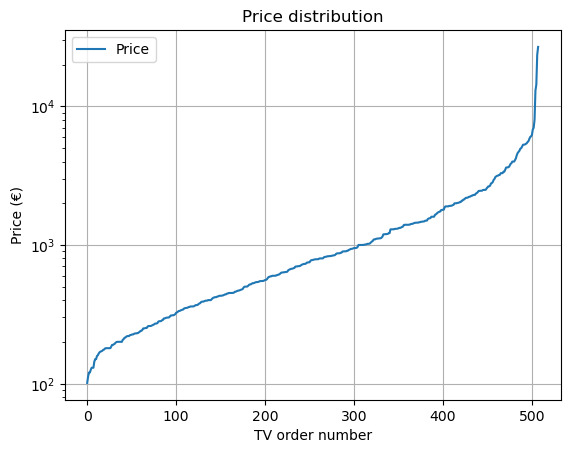

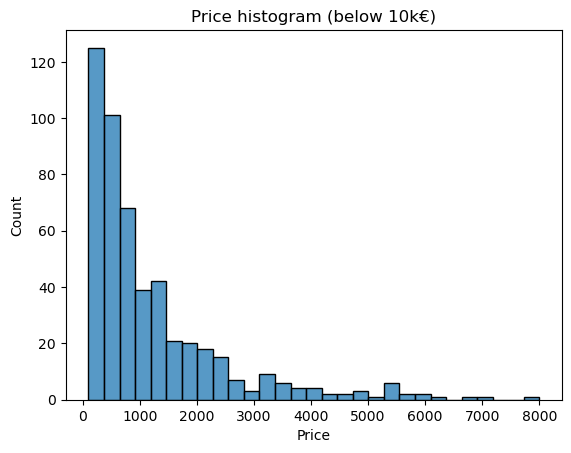

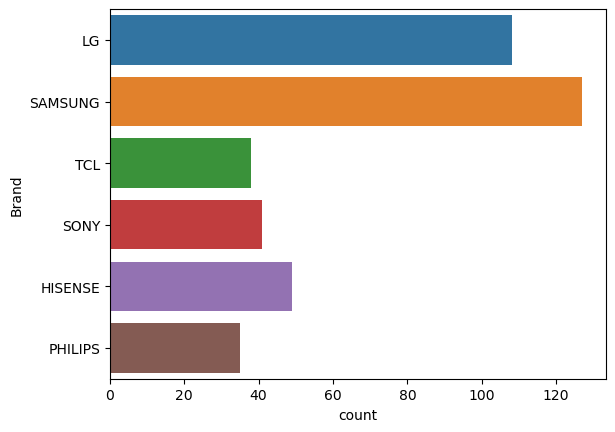

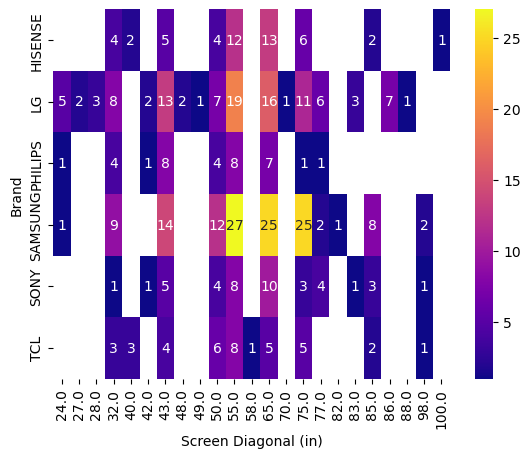

In [11]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Start by fetching the data
df = pd.read_excel('data/cleaned_data.xlsx')

# Sort the prices and plot on a logarithmic scale
ax = df.sort_values('Price').reset_index().plot(y='Price', logy=True, title='Price distribution')
ax.set_xlabel('TV order number')
ax.set_ylabel("Price (€)")
ax.grid()
plt.show()

# Plot a histogram of TVs prices below 10,000€
ax = sns.histplot(data=df[df['Price']<1e4], x='Price')
ax.set_title('Price histogram (below 10k€)')
plt.show()




df = df.groupby('Brand').filter(lambda x: len(x) > 20)
sns.countplot(y="Brand", data=df)
plt.show()

df2 = pd.pivot_table(values ='Price', index ='Brand', columns ='Screen Diagonal (in)', data = df, aggfunc=len)#, fill_value=0)
# df = pd.pivot_table(values ='Price', index ='Screen Type', columns ='Screen Diagonal (in)', data = df, aggfunc=np.mean)#, fill_value=0)
sns.heatmap(df2, cmap ='plasma', annot=True)
plt.show()

#df.plot.hist(y='Brand')
#df.set_index('Date', inplace=True)
#df.groupby('ticker')['adj_close'].plot(legend=True)
# df.boxplot(by ='day', column =['total_bill'], grid = False)
# df.boxplot(by='Brand', column=['Price'])
#df.plot.scatter(x='Area', y='Price')
#df.plot.hist(y='Screen Diagonal (in)', edgecolor='black')
#sns.lineplot(x="Screen Diagonal (cm)", y="Price", hue="Screen Type", data=df)
#
#df.plot.scatter(x='Screen Diagonal (cm)', y='Price', logy=True)

